In [1]:
# Import libraries.
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import string
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Read in saved song data csv's as one DataFrame.
master1 = pd.read_csv('master_lyrics_data.csv')
master2 = pd.read_csv('master_lyrics_data2.csv')
master = pd.concat((master1, master2), axis=0).dropna(axis=0, how='any').reset_index(drop=True)

# Remove three specific tracks that had junk lyrics.
for ind in master[(master.song == 'battle hymn') | (master.song == 'primary') | (master.song == 'non puoi lasciarmi così')].index.values:
    master = master.drop(ind)
    
master = master.reset_index(drop=True)

master.head()

,lyrics,song,album,artist,genre
0,"Say your prayers, little one Don't forget, my ...",enter sandman,metallica,metallica,heavy metal
1,Hey (hey) I'm your life I'm the one who takes ...,sad but true,metallica,metallica,heavy metal
2,No more! The crap rolls out your mouth again H...,holier than thou,metallica,metallica,heavy metal
3,New blood joins this earth And quickly he's su...,the unforgiven,metallica,metallica,heavy metal
4,(And the road becomes my bride) And the road b...,wherever i may roam,metallica,metallica,heavy metal


In [3]:
master.genre.value_counts()

country        891
heavy metal    623
rap            568
rock           489
pop            435
Name: genre, dtype: int64

Overall, a decent amount of songs.

In [4]:
# Tokenize all lyrics, remove punctuations other than contraction apostrphes.
# Count lyric's character length, token count, mean token length and contraction count.
tknzr = nltk.TweetTokenizer()
token_count = []
is_contractions = ["she's", "he's", "it's", "there's", "who's", "what's", 
                   "where's", "when's", "how's", "why's", "that's"]
contraction_counter_list = []
string_len = []
avg_token_len = []

for lyric in master.lyrics:
    contraction_counter = 0
    tokens = tknzr.tokenize(lyric)
    list_ = [token for token in tokens if token not in string.punctuation]
    token_count.append(len(list_))
    for token in list_:
        if "'" in token and token[-2:] != "'s":
            contraction_counter += 1
        if token in is_contractions:
            contraction_counter += 1
    contraction_counter_list.append(contraction_counter)
    string_len.append(len(lyric))
    token_sums = [len(token) for token in list_]
    avg_token_len.append(np.sum(token_sums)/len(token_sums))

# Store lyric's character length, token count, mean token length and contraction count in 'master' DataFrame.
master['lyric_string_length'] = string_len
master['total_token_count'] = token_count
master['avg_token_length'] = avg_token_len
master['contraction_count'] = contraction_counter_list

master.head()

,lyrics,song,album,artist,genre,lyric_string_length,total_token_count,avg_token_length,contraction_count
0,"Say your prayers, little one Don't forget, my ...",enter sandman,metallica,metallica,heavy metal,1246,245,3.951020,11
1,Hey (hey) I'm your life I'm the one who takes ...,sad but true,metallica,metallica,heavy metal,1435,287,3.832753,52
2,No more! The crap rolls out your mouth again H...,holier than thou,metallica,metallica,heavy metal,885,169,4.130178,4
3,New blood joins this earth And quickly he's su...,the unforgiven,metallica,metallica,heavy metal,1571,298,4.231544,26
4,(And the road becomes my bride) And the road b...,wherever i may roam,metallica,metallica,heavy metal,1585,309,3.996764,14


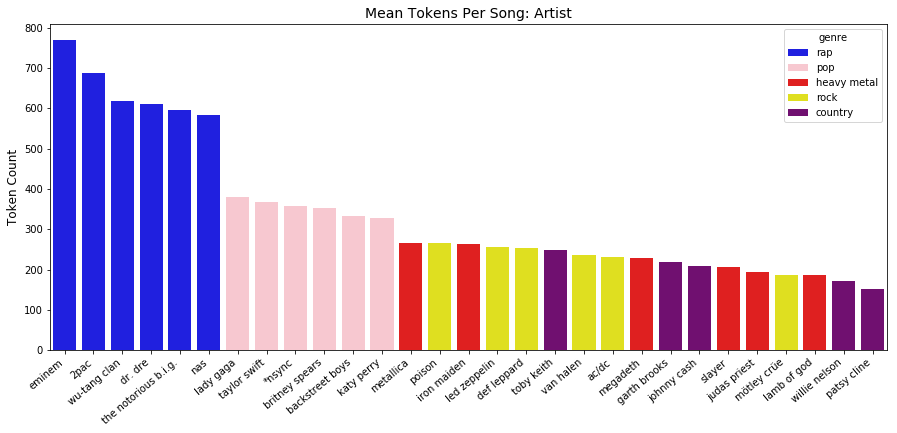

In [5]:
# Plot each artist's mean tokens per song.
genres = master[['artist', 'genre']].drop_duplicates('artist').sort_values('artist').set_index('artist').genre

artist_mean_tokens = pd.concat((master.artist, master.total_token_count), axis=1).groupby('artist').mean()
artist_mean_tokens = pd.concat((artist_mean_tokens, genres), axis=1, ignore_index=True)
artist_mean_tokens.columns = ['word_count', 'genre']
artist_mean_tokens = artist_mean_tokens.sort_values('word_count', ascending=False)

colormap = {'heavy metal': 'red', 
            'rap': 'blue', 
            'pop': 'pink', 
            'country': 'purple', 
            'rock': 'yellow'}

plt.figure(figsize=(15,6))
sns.barplot(x=artist_mean_tokens.index, 
            y=artist_mean_tokens.word_count, 
            data=artist_mean_tokens, 
            hue='genre', 
            dodge=False, 
            palette=colormap)
plt.xticks(rotation=40, ha='right')
plt.xlabel('')
plt.ylabel('Token Count', fontsize=12)
plt.title('Mean Tokens Per Song: Artist', fontsize=14)
plt.show()

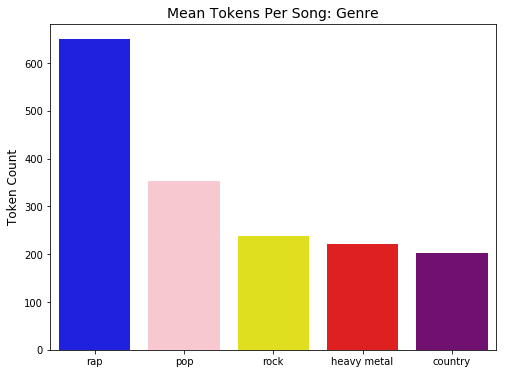

In [6]:
# Plot each genre's mean tokens per song.
genre_mean_tokens = pd.concat((master.genre, master.total_token_count), axis=1).groupby('genre').mean()
genre_mean_tokens.columns = ['word_count']
genre_mean_tokens = genre_mean_tokens.sort_values('word_count', ascending=False)

colormap = {'heavy metal': 'red', 
            'rap': 'blue', 
            'pop': 'pink', 
            'country': 'purple', 
            'rock': 'yellow'}

plt.figure(figsize=(8,6))
sns.barplot(x=genre_mean_tokens.index, 
            y=genre_mean_tokens.word_count, 
            data=genre_mean_tokens, 
            hue=genre_mean_tokens.index, 
            dodge=False, 
            palette=colormap).legend_.remove()
plt.xlabel('')
plt.ylabel('Token Count', fontsize=12)
plt.title('Mean Tokens Per Song: Genre', fontsize=14)
plt.show()

A common issue encountered when working with lyric text is the use of common slang, like ending words with "in" rather than "ing", using "wanna" rather than "want to", etc.  Over several iteration of collecting frequent misspellings and other junk words like "haha" and "chika chika", I compiled a thorough list of tokens to remove because they had no value and others to edit into regular spelling

In [7]:
stop_words = ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', 
              "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 
              'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 
              'don',"don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 
              'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him',
              'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 
              'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself',
              'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 
              'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 
              'should', "should've", 'shouldn', "shouldn't", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the',
              'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 
              'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we', 'were', 'weren',
              "weren't", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't",
              'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself',
              'yourselves', 'yo', 'oh', 'yeah', 'ooh', 'ow', 'cha', 'rahh', 'ah', 'ya', 'yuh', 'hey', 'boooooo', 'na',
              'le','la', 'aha', 'ahah', 'ahaha', 'ahahaha', 'ahahahaha', 'ahe','ahh', 'ahhah', 'ahhh', 'ahhhah', 'ahhhh', 'ahhhhh',
              'aoowww', 'amin', 'assin', 'ckin', 'uh', 'mmm', 'nah', 'mma', 'pum', 'hoo', 'woah', 'hmm', 'wooh', 'weh',
              'heh', 'ry', 'ohh', 'hahaha', 'aiyyo', 'haha', 'chika', 'doo', 'ev', 'erra', 'chie', 'ee', 'ayo', 'sheesh', 
              'qb', 'dem', 'oooh', 'ki', 'aiyo', 'nuh', 'hmmm', 'aah', 'whatz', 'tcha', 'doh', 'ries', 'chicka', 'blaow', 
              'ob', 'ittle', 'hou', 'hanneman', 'hahahaha', 'cr', 'aww', 'yay', 'shh', 'oops', 'olu', 'ii', 'hella', 
              'wim', 'ha', 'wup', 'tra', 'get', 'would', 'could', 'should', 'yes', 'no', 'whoa', 'mon', 'come', 'gots', 
              'puh','fuh', 'hoah', 'duh', 'hah', 'know']

word_edit = {'till': 'until', 'motherfuckin': 'motherfucking', 'aight': 'alright', "ol'": 'old', 'ol': 'old',
             'playiyay': 'play', 'yah': 'you', 'gonna': 'going to', 'wanna': 'want to', 'kinda': 'kind of', 
             'gotcha': 'got you', 'atcha': 'at you', 'wrecka': 'wrecker', 'em': 'them', 'masta': 'master', 
             'wit': 'with', 'fuckin': 'fucking', 'imma': 'i am going to', 'illa': 'iller', 'wuz': 'was', 
             'nuff': 'enough', 'getcha': 'get you', 'gatcha': 'gat you', 'whadeva': 'whatever', 'outta': 'out of', 
             'absorbin': 'absorbing', 'abusin': 'abusing', 'acceptin': 'accepting', 'achin': 'aching', 
             'acvtivatin': 'acvtivating', 'adaptin': 'adapting', 'addin': 'adding', 'addressin': 'addressing', 
             'admirin': 'admiring', 'adoptin': 'adopting', 'affectin': 'affecting', 'aggravatin': 'aggravating', 
             'agreein': 'agreeing', 'aimin': 'aiming', 'amazin': 'amazing', 'analyzin': 'analyzing', 
             'annoyin': 'annoying', 'anticipatin': 'anticipating', 'apoligizin': 'apoligizing', 
             'appallin': 'appalling', 'appearin': 'appearing', 'applyin': 'applying', 'approachin': 'approaching', 
             'arguin': 'arguing', 'askin': 'asking', 'asphyxiatin': 'asphyxiating', 'assemblin': 'assembling', 
             'assumin': 'assuming', 'attractin': 'attracting', 'avoidin': 'avoiding', 'babblin': 'babbling', 
             'backdoorslammin': 'backdoorslamming', 'backin': 'backing', 'backstabbin': 'backstabbing', 
             'baggin': 'bagging', 'bailin': 'bailing', 'bakin': 'baking', 'ballin': 'balling', 
             'balllin': 'balling', 'bangin': 'banging', 'bankin': 'banking', 'bargainin': 'bargaining', 
             'barkin': 'barking', 'bathin': 'bathing', 'battin': 'batting', 'battlin': 'battling', 
             'bawlin': 'bawling', 'bblastin': 'blasting', 'beamin': 'beaming', 'beatin': 'beating', 
             'becomin': 'becoming', 'beggin': 'begging', 'beginnin': 'beginning', 'bein': 'being', 
             'believin': 'believing', 'bendin': 'bending', 'bettin': 'betting', 'biddin': 'bidding', 
             'billin': 'billing', 'bitchin': 'bitching', 'bitin': 'biting', 'blackin': 'blacking', 
             'blamin': 'blaming', 'blastin': 'blasting', 'blazin': 'blazing', 'bleachin': 'bleaching', 
             'bleedin': 'bleeding', 'blessin': 'blessing', 'blindin': 'blinding', 'blinkin': 'blinking', 
             'blisterin': 'blistering', 'blockin': 'blocking', 'bloggin': 'blogging', 'bloodin': 'blooding', 
             'blowin': 'blowing', 'bluffin': 'bluffing', 'blushin': 'blushing', 'bodyin': 'bodying', 
             'bogglin': 'boggling', 'boilin': 'boiling', 'bokin': 'boking', 'bombin': 'bombing', 'bonin': 
             'boning', 'bookin': 'booking', 'boostin': 'boosting', 'boozin': 'boozing', 'boppin': 'bopping', 
             'borin': 'boring', 'bossin': 'bossing', 'botherin': 'bothering', 'bouncin': 'bouncing', 'boxin': 
             'boxing', 'braggin': 'bragging', 'brawlin': 'brawling', 'brayin': 'braying', 'breakin': 'breaking', 
             'breathin': 'breathing', 'bringin': 'bringing', 'brokin': 'broking', 'bruisin': 'bruising', 
             'brushin': 'brushing', 'bubblin': 'bubbling', 'buckin': 'bucking', 'buggin': 'bugging', 
             'buildin': 'building', 'buillshittin': 'bullshitting', 'bulgin': 'bulging', 
             'bullshitin': 'bullshitting', 'bullshittin': 'bullshitting', 'bumblin': 'bumbling', 'bumpin': 'bumping', 
             'burnin': 'burning', 'burryin': 'burying', 'buryin': 'burying', 'bustin': 'busting', 'buyin': 'buying', 
             'buzzin': 'buzzing', 'cakin': 'caking', 'callin': 'calling', 'carin': 'caring', 
             'carressin': 'carressing', 'carryin': 'carrying', 'cashin': 'cashing', 'castin': 'casting', 
             'catchin': 'catching', 'causin': 'causing', 'cavortin': 'cavorting', 'ceilin': 'ceiling', 
             'celebratin': 'celebrating', 'chainin': 'chaining', 'changin': 'changing', 'channelin': 'channeling', 
             'chantin': 'chanting', 'chargin': 'charging', 'chasin': 'chasing', 'chatterin': 'chattering', 
             'chattin': 'chatting', 'cheatin': 'cheating', 'checkin': 'checking', 'chewin': 'chewing', 
             'chillin': 'chilling', 'chokin': 'choking', 'choosin': 'choosing', 'choppin': 'chopping', 
             'churnin': 'churning', 'circlin': 'circling', 'claimin': 'claiming', 'clappin': 'clapping', 
             'clashin': 'clashing', 'cleanin': 'cleaning', 'clearin': 'clearing', 'clickin': 'clicking', 
             'climaxin': 'climaxing', 'climbin': 'climbing', 'clingin': 'clinging', 'clockin': 'clocking', 
             'closin': 'closing', 'clothin': 'clothing', 'clownin': 'clowning', 'clubbin': 'clubbing', 
             'clutchin': 'clutching', 'coachin': 'coaching', 'coastin': 'coasting', 'cockin': 'cocking', 
             'codesignin': 'code signing', 'cokein': 'cokeing', 'collapsin': 'collapsing', 'collectin': 
             'collecting', 'collidin': 'colliding', 'combinin': 'combining', 'comin': 'coming', 
             'commin': 'coming', 'committin': 'committing', 'communicatin': 'communicating', 
             'competin': 'competing', 'complainin': 'complaining', 'complicatin': 'complicating', 
             'concealin': 'concealing', 'confusin': 'confusing', 'connivin': 'conniving', 'consolin': 'consoling', 
             'contemplatin': 'contemplating', 'contractin': 'contracting', 'controllin': 'controlling', 
             'conversatin': 'conversating', 'convincin': 'convincing', 'cooin': 'cooing', 'cookin': 'cooking', 
             'coolin': 'cooling', 'counselin': 'counseling', 'countin': 'counting', 'coverin': 'covering', 
             'crackin': 'cracking', 'cracklin': 'crackling', 'crashin': 'crashing', 'cravin': 'craving', 
             'crawlin': 'crawling', 'creatin': 'creating', 'creepin': 'creeping', 'critiquin': 'critiquing', 
             'croakin': 'croaking', 'crossin': 'crossing', 'cruisin': 'cruising', 'crushin': 'crushing', 
             'cryin': 'crying', 'crypin': 'cryping', 'cuddlin': 'cuddling', 'cuppin': 'cupping', 
             'cursin': 'cursing', 'cushin': 'cushing', 'cussin': 'cussing', 'cuttin': 'cutting', 
             'dallyin': 'dallying', 'dancin': 'dancing', 'darlin': 'darling', 'dartin': 'darting', 
             'datin': 'dating', 'daydreamin': 'daydreaming', 'dealin': 'dealing', 'debatin': 'debating', 
             'decapitatin': 'decapitating', 'deceivin': 'deceiving', 'decidin': 'deciding', 
             'dedicatin': 'dedicating', 'defendin': 'defending', 'deficatin': 'deficating', 
             'deliverin': 'delivering', 'demandin': 'demanding', 'demonstratin': 'demonstrating', 
             'denyin': 'denying', 'dependin': 'depending', 'depositin': 'depositing', 'depressin': 'depressing', 
             'deservin': 'deserving', 'despisin': 'despising', 'destroyin': 'destroying', 
             'devastatin': 'devastating', 'devin': 'deving', 'devisin': 'devising', 'devourin': 'devouring', 
             'dickin': 'dicking', 'diggin': 'digging', 'dimin': 'dimming', 'dimmin': 'dimming', 'dinin': 'dining', 
             'dippin': 'dipping', 'disappearin': 'disappearing', 'discriminatin': 'discriminating', 
             'discussin': 'discussing', 'disgustin': 'disgusting', 'dishin': 'dishing', 
             'disintegratin': 'disintegrating', 'dispensin': 'dispensing', 'displayin': 'displaying', 
             'dissapearin': 'dissapearing', 'dissin': 'dissing', 'dividin': 'dividing', 'dodgin': 'dodging', 
             'doggin': 'dogging', 'doin': 'doing', 'doublin': 'doubling', 'doubtin': 'doubting', 
             'draggin': 'dragging', 'dragin': 'dragging', 'drainin': 'draining', 'drawin': 'drawing', 
             'dreadin': 'dreading', 'dreamin': 'dreaming', 'drenchin': 'drenching', 'dressin': 'dressing', 
             'driftin': 'drifting', 'drillin': 'drilling', 'drinkin': 'drinking', 'drippin': 'dripping', 
             'drivin': 'driving', 'droolin': 'drooling', 'dropin': 'dropping', 'droppin': 'dropping', 
             'drownin': 'drowning', 'drummin': 'drumming', 'drunkin': 'drunken', 'dubbin': 'dubbing', 
             'duckin': 'ducking', 'dumbin': 'dumbing', 'dumpin': 'dumping', 'dunkin': 'dunking', 
             'durin': 'during', 'dustin': 'dusting', 'dutchin': 'dutching', 'dwarfin': 'dwarfing', 
             'dwellin': 'dwelling', 'dyin': 'dying', 'eatin': 'eating', 'effin': 'effing', 'eggin': 'egging', 
             'ejectin': 'ejecting', 'eliminatin': 'eliminating', 'embarrassin': 'embarrassing', 
             'embracin': 'embracing', 'emergin': 'emerging', 'endin': 'ending', 'enjoyin': 'enjoying', 
             'enterin': 'entering', 'enterprisin': 'enterprising', 'entertainin': 'entertaining', 
             'envisionin': 'envisioning', 'erasin': 'erasing', 'evadin': 'evading', 'evenin': 'evening', 
             'everlastin': 'everlasting', 'everythin': 'everything', 'excitin': 'exciting', 
             'executin': 'executing', 'exisitin': 'exisiting', 'expandin': 'expanding', 'expectin': 'expecting', 
             'expellin': 'expelling', 'experiencin': 'experiencing', 'explodin': 'exploding', 
             'eyeballin': 'eyeballing', 'eyein': 'eyeing', 'facin': 'facing', 'fackin': 'facking', 
             'fadin': 'fading', 'faintin': 'fainting', 'fakin': 'faking', 'fallin': 'falling', 
             'fantasizin': 'fantasizing', 'farmin': 'farming', 'fazin': 'fazing', 'fearin': 'fearing', 
             'feedin': 'feeding', 'feelin': 'feeling', 'feenin': 'fiending', 'fellin': 'felling', 
             'fiendin': 'fiending', 'fightin': 'fighting', 'figurin': 'figuring', 'fillin': 'filling', 
             'filmin': 'filming', 'findin': 'finding', 'finishin': 'finishing', 'finnickin': 'finnicking', 
             'firin': 'firing', 'fishin': 'fishing', 'fistboxin': 'fistboxing', 'fistin': 'fisting', 
             'fittin': 'fitting', 'fixin': 'fixing', 'flaggin': 'flagging', 'flamin': 'flaming', 
             'flappin': 'flapping', 'flarin': 'flaring', 'flashin': 'flashing', 'flexin': 'flexing', 
             'flippin': 'flipping', 'floatin': 'floating', 'flossin': 'flossing', 'flowin': 'flowing', 
             'flushin': 'flushing', 'flyin': 'flying', 'focusin': 'focusing', 'foldin': 'folding', 
             'followin': 'following', 'foolin': 'fooling', 'forcin': 'forcing', 'forgettin': 'forgetting', 
             'forgivin': 'forgiving', 'formulatin': 'formulating', 'forthcomin': 'forthcoming', 
             'foulin': 'fouling', 'freakin': 'freaking', 'freestylin': 'freestyling', 'freezin': 'freezing', 
             'frightenin': 'frightening', 'frightnin': 'frightening', 'frontin': 'fronting', 
             'frownin': 'frowning', 'fryin': 'frying', 'fufillin': 'fulfilling', 'fulfillin': 'fulfilling', 
             'fumin': 'fuming', 'fussin': 'fussing', 'gainin': 'gaining', 'gamblin': 'gambling', 
             'gangbangin': 'gangbanging', 'gangbanin': 'gangbanging', 'gasolinin': 'gasoline', 
             'gaspin': 'gasping', 'gassin': 'gassing', 'gatherin': 'gathering', 'gawkin': 'gawking', 
             'gazin': 'gazing', 'gettin': 'getting', 'ghostin': 'ghosting', 'givin': 'giving', 
             'gleamin': 'gleaming', 'glidin': 'gliding', 'glistenin': 'glistening', 'glockin': 'glocking', 
             'glorifyin': 'glorifying', 'glowin': 'glowing', 'gluin': 'gluing', 'goin': 'going', 
             'golddiggin': 'golddigging', 'golfin': 'golfing', 'gougin': 'gouging', 'governin': 'governing', 
             'grabbin': 'grabbing', 'grievin': 'grieving', 'grillin': 'grilling', 'grindin': 'grinding', 
             'grinin': 'grinning', 'grinnin': 'grinning', 'grippin': 'gripping', 'groanin': 'groaning', 
             'groovin': 'grooving', 'growin': 'growing', 'guaranteein': 'guaranteeing', 'guessin': 'guessing', 
             'gunnin': 'gunning', 'guzzlin': 'guzzling', 'hailin': 'hailing', 'hallicinatin': 'hallucinating', 
             'hallucinatin': 'hallucinating', 'handin': 'handing', 'handlin': 'handling', 'hangin': 'hanging', 
             'happenin': 'happening', 'happennin': 'happening', 'harassin': 'harassing', 
             'harmonizin': 'harmonizing', 'hasslin': 'hassling', 'hastin': 'hasting', 'hatin': 'hating', 
             'haulin': 'hauling', 'hauntin': 'haunting', 'havin': 'having', 'hawkin': 'hawking', 
             'hazin': 'hazing', 'headin': 'heading', 'healin': 'healing', 'hearin': 'hearing', 
             'heatin': 'heating', 'helpin': 'helping', 'hesitatin': 'hesitating', 'hidin': 'hiding', 
             'hijackin': 'hijacking', 'hitin': 'hitting', 'hittin': 'hitting', 'hoein': 'hoeing', 
             'holdin': 'holding', 'hollerin': 'hollering', 'homecomin': 'homecoming', 'honkin': 'honking', 
             'hookin': 'hooking', 'hootin': 'hooting', 'hopin': 'hoping', 'hoppin': 'hopping', 
             'housin': 'housing', 'howlin': 'howling', 'huffin': 'huffing', 'huggin': 'hugging', 
             'hummin': 'humming', 'humpin': 'humping', 'huntin': 'hunting', 'hurtin': 'hurting', 
             'hustlin': 'hustling', 'icin': 'icing', 'illin': 'illing', 'imagin': 'imaging', 
             'imaginin': 'imagining', 'impressin': 'impressing', 'inflictin': 'inflicting', 'innin': 'inning', 
             'interestin': 'interesting', 'intergratin': 'intergrating', 'interrogatin': 'interrogating', 
             'intertwinin': 'intertwining', 'introducin': 'introducing', 'investin': 'investing', 
             'invitin': 'inviting', 'ironin': 'ironing', 'irritatin': 'irritating', 'itchin': 'itching', 
             'jackin': 'jacking', 'jammin': 'jamming', 'jeapordizin': 'jeapordizing', 'jettin': 'jetting', 
             'jockin': 'jocking', 'jokin': 'joking', 'jottin': 'jotting', 'judgin': 'judging', 
             'jugglin': 'juggling', 'juicin': 'juicing', 'jumpin': 'jumping', 'justin': 'justing', 
             'keepin': 'keeping', 'kickin': 'kicking', 'kiddin': 'kidding', 'kidnappin': 'kidnapping', 
             'killin': 'killing', 'kingin': 'kinging', 'kissin': 'kissing', 'knahmsayin': 'know what i am saying', 
             'knifin': 'knifing', 'knockin': 'knocking', 'knowhatimsayin': 'know what i am saying', 
             'knowin': 'knowing', 'lampin': 'lamping', 'landin': 'landing', 'lastin': 'lasting', 
             'laughin': 'laughing', 'launchin': 'launching', 'layin': 'laying', 'leakin': 'leaking', 
             'leanin': 'leaning', 'leapin': 'leaping', 'learnin': 'learning', 'leavin': 'leaving', 
             'lettin': 'letting', 'levatatin': 'levatating', 'lickin': 'licking', 
             'lifemotherfuckin': 'life motherfucking', 'lifin': 'lifing', 'liftin': 'lifting', 
             'lightin': 'lighting', 'lightnin': 'lightning', 'linkin': 'linking', 'listenin': 'listening', 
             'listin': 'listing', 'livin': 'living', 'loadin': 'loading', 'loafin': 'loafing', 
             'loathin': 'loathing', 'lockin': 'locking', 'lokin': 'locking', 'lookin': 'looking', 
             'loopin': 'looping', 'loosin': 'losing', 'losin': 'losing', 'loungin': 'lounging', 'lovin': 'loving', 
             'lurkin': 'lurking', 'lustin': 'lusting', 'lyin': 'lying', 'lynchin': 'lynching', 'mackin': 'macking',
             'makin': 'making', 'manifestin': 'manifesting', 'marchin': 'marching', 'marryin': 'marrying',
             'mashin': 'mashing', 'masturbatin': 'masturbating', 'matchin': 'matching', 'maxin': 'maxing', 
             'mcin': 'mcing', 'mdoin': 'mdoing', 'meanin': 'meaning', 'measurin': 'measuring', 
             'meditatin': 'meditating', 'meltin': 'melting', 'mendin': 'mending', 'mentionin': 'mentioning',
             'mindin': 'minding', 'mindscapin': 'mindscaping', 'miragin': 'miraging', 'missin': 'missing', 
             'mistakin': 'mistaking', 'mistin': 'misting', 'misusin': 'misusing', 'mixin': 'mixing', 
             'moanin': 'moaning', 'mobbin': 'mobbing', 'modelin': 'modeling', 'moldin': 'molding', 
             'molestin': 'molesting', 'moppin': 'mopping', 'mornin': 'morning', 'morphin': 'morphing', 
             'mothafuckin': 'motherfucking', 'mothefuckin': 'motherfucking', 'mournin': 'mourning', 
             'mouthin': 'mouthing', 'movin': 'moving', 'mowin': 'mowing', 'muggin': 'mugging', 
             'muhfuckin': 'motherfucking', 'murderin': 'murdering', 'muthafuckin': 'motherfucking', 
             'mutherfuckin': 'motherfucking', 'mystifyin': 'mystifying', 'nappin': 'napping', 
             'needin': 'needing', 'noddin': 'nodding', 'nothin': 'nothing', 'nursin': 'nursing', 
             'nuttin': 'nutting', 'obeyin': 'obeying', 'obscurin': 'obscuring', 'observin': 'observing', 
             'offendin': 'offending', 'oilin': 'oiling', 'openin': 'opening', 'outlastin': 'outlasting', 
             'outweighin': 'outweighing', 'overdosin': 'overdosing', 'overtakin': 'overtaking', 
             'overthuggin': 'overthugging', 'overwhelmin': 'overwhelming', 'ownin': 'owning', 
             'pacin': 'pacing', 'packin': 'packing', 'pagin': 'paging', 'paintin': 'painting', 
             'palmin': 'palming', 'pamprin': 'pampering', 'panicin': 'panicking', 'paperchasin': 'paper chasing',
             'paralyzin': 'paralyzing', 'parasailin': 'parasailing', 'partyin': 'partying', 'passin': 'passing', 
             'pattin': 'patting', 'pawin': 'pawing', 'payin': 'paying', 'pealin': 'peeling', 'peddlin': 'peddling',
             'peekin': 'peeking', 'peelin': 'peeling', 'peepin': 'peeping', 'penetratin': 'penetrating',
             'performin': 'performing', 'perishin': 'perishing', 'pervertin': 'perverting', 'pervin': 'perving',
             'phonin': 'phoning', 'pickin': 'picking', 'pillin': 'pilling', 'pimpin': 'pimping',
             'pinchin': 'pinching', 'pissin': 'pissing', 'pitchin': 'pitching', 'placin': 'placing', 
             'plannin': 'planning', 'plantin': 'planting', 'playin': 'playing', 'pleadin': 'pleading',
             'pleasin': 'pleasing', 'plinklin': 'plinkling', 'plottin': 'plotting', 'pluckin': 'plucking',
             'pockin': 'pocking', 'pointin': 'pointing', 'pokin': 'poking', 'polishin': 'polishing', 
             'pollutin': 'polluting', 'pollyin': 'pollying', 'popin': 'poping', 'posin': 'posing', 
             'poundin': 'pounding', 'pourin': 'pouring', 'prayin': 'praying', 'preachin': 'preaching', 
             'pressin': 'pressing', 'pretendin': 'pretending', 'printin': 'printing', 'professin': 'professing',
             'prosperin': 'prospering', 'protectin': 'protecting', 'protestin': 'protesting', 
             'providin': 'providing', 'provin': 'proving', 'pryin': 'prying', 'publishin': 'publishing',
             'puddin': 'pudding', 'pulin': 'puling', 'pullin': 'pulling', 'pumpin': 'pumping', 
             'punchin': 'punching', 'punishin': 'punishing', 'pursuin': 'pursuing', 'pushin': 'pushing', 
             'pussyfootin': 'pussyfooting', 'puttin': 'putting', 'quackin': 'quacking', 
             'questionin': 'questioning', 'quittin': 'quitting', 'quiverin': 'quivering', 'racin': 'racing',
             'raggin': 'ragging', 'ragin': 'raging', 'rainin': 'raining', 'ramblin': 'rambling', 
             'rapin': 'raping', 'rappin': 'rapping', 'rappinin': 'rapping', 'rarin': 'raring', 
             'rattin': 'ratting', 'rattlin': 'rattling', 'reachin': 'reaching', 'reactin': 'reacting', 
             'readin': 'reading', 'realizin': 'realizing', 'reapin': 'reaping', 'rearrangin': 'rearranging', 
             'receivin': 'receiving', 'reclinin': 'reclining', 'recordin': 'recording', 'recoupin': 'recouping',
             'recoverin': 'recovering', 'recruitin': 'recruiting', 'reelin': 'reeling', 'reflectin': 'reflecting',
             'regulatin': 'regulating', 'relatin': 'relating', 'relaxin': 'relaxing', 'releasin': 'releasing',
             'relievin': 'relieving', 'remainin': 'remaining', 'rememberin': 'remembering', 
             'reminiscin': 'reminiscing', 'reminissin': 'reminiscing', 'repeatin': 'repeating',
             'reppin': 'repping', 'representin': 'representing', 'restin': 'resting', 'revealin': 'revealing',
             'revvin': 'revving', 'rewindin': 'rewinding', 'rhymin': 'rhyming', 'richochetin': 'richocheting',
             'ridin': 'riding', 'riffin': 'riffing', 'ringin': 'ringing', 'rippin': 'ripping', 'risin': 'rising',
             'roamin': 'roaming', 'roarin': 'roaring', 'rockin': 'rocking', 'rollin': 'rolling', 
             'romancin': 'romancing', 'rottin': 'rotting', 'rousin': 'rousing', 'rubbin': 'rubbing', 
             'ruinin': 'ruining', 'runnin': 'running', 'rushin': 'rushing', 'rustin': 'rusting', 
             'ryhmin': 'ryhming', 'sabotagin': 'sabotaging', 'sackin': 'sacking', 'saggin': 'sagging', 
             'sailin': 'sailing', 'salivatin': 'salivating', 'samplin': 'sampling', 'satisfyin': 'satisfying', 
             'sayin': 'saying', 'scalin': 'scaling', 'scannin': 'scanning', 'scarin': 'scaring', 
             'scatterin': 'scattering', 'scattin': 'scatting', 'schemin': 'scheming', 'schoolin': 'schooling', 
             'scopin': 'scoping', 'scorin': 'scoring', 'scramblin': 'scrambling', 'scrapin': 'scraping',
             'scrappin': 'scraping', 'scratchin': 'scratching', 'screamin': 'screaming', 'screwin': 'screwing',
             'searchin': 'searching', 'seasonin': 'seasoning', 'seatin': 'seating', 'seducin': 'seducing', 
             'seein': 'seeing', 'seekin': 'seeking', 'selectin': 'selecting', 'sellin': 'selling', 
             'sendin': 'sending', 'sensin': 'sensing', 'sentencin': 'sentencing', 'seperatin': 'seperating', 
             'servin': 'serving', 'settin': 'setting', 'settlin': 'settling', 'sewin': 'sewing', 
             'sexin': 'sexing', 'shacklin': 'shackling', 'shakin': 'shaking', 'shapin': 'shaping', 
             'sharin': 'sharing', 'sharpenin': 'sharpening', 'sheddin': 'shedding', 'shiftin': 'shifting', 
             'shinin': 'shining', 'shinnin': 'shining', 'shippin': 'shipping', 'shittin': 'shitting', 
             'shiverin': 'shivering', 'shogunnin': 'shogunning', 'shootin': 'shooting', 'shoppin': 'shopping',
             'shoutin': 'shouting', 'shovin': 'shoving', 'showin': 'showing', 'shrinkin': 'shrinking', 
             'shuttin': 'shutting', 'sickenin': 'sickening', 'sickin': 'sicking', 'sighin': 'sighing', 
             'signin': 'signing', 'simpin': 'simping', 'singin': 'singing', 'sinkin': 'sinking', 
             'sinnin': 'sinning', 'sippin': 'sipping', 'sitfin': 'sitfing', 'sitin': 'siting', 'sittin': 'sitting',
             'skeemin': 'scheming', 'skeezin': 'skeezing', 'sketchin': 'sketching', 'skewin': 'skewing', 
             'skippin': 'skipping', 'slammin': 'slamming', 'slangin': 'slanging', 'slavin': 'slaving', 
             'slayin': 'slaying', 'sleepin': 'sleeping', 'sleppin': 'sleeping', 'slicin': 'slicing', 
             'slidin': 'sliding', 'slingin': 'slinging', 'slippin': 'slipping', 'slittin': 'slitting', 
             'slobbin': 'slobbing', 'slowin': 'slowing', 'sluggin': 'slugging', 'smackin': 'smacking',
             'smartin': 'smarting', 'smearin': 'smearing', 'smellin': 'smelling', 'smilin': 'smiling', 
             'smokin': 'smoking', 'smolderin': 'smoldering', 'smugglin': 'smuggling', 'smurfin': 'smurfing',
             'snackin': 'snacking', 'snappin': 'snapping', 'snatchin': 'snatching', 'sneakin': 'sneaking',
             'sniffin': 'sniffing', 'snitchin': 'snitching', 'snorin': 'snoring', 'snortin': 'snorting',
             'snowboardin': 'snowboarding', 'snuffin': 'snuffing', 'soakin': 'soaking', 'sobbin': 'sobbing',
             'soggin': 'sogging', 'somethin': 'something', 'sometihin': 'something', 'soundin': 'sounding', 
             'sparkin': 'sparking', 'sparklin': 'sparkling', 'spazzin': 'spazzing', 'speakin': 'speaking', 
             'speedin': 'speeding', 'spellin': 'spelling', 'spendin': 'spending', 'spikin': 'spiking',
             'spillin': 'spilling', 'spinnin': 'spinning', 'spittin': 'spitting', 'splashin': 'splashing', 
             'splatterin': 'splattering', 'splurgin': 'splurging', 'spoilin': 'spoiling', 'sportin': 'sporting',
             'spottin': 'spotting', 'sprayin': 'spraying', 'spreadin': 'spreading', 'sprinklin': 'sprinkling',
             'spyin': 'spying', 'squawtin': 'squatting', 'squealin': 'squealing', 'squeezin': 'squeezing',
             'squirtin': 'squirting', 'stabbin': 'stabbing', 'stackin': 'stacking', 'staggerin': 'staggering', 
             'stallin': 'stalling', 'stampedin': 'stampeding', 'standin': 'standing', 'stankin': 'stanking', 
             'starin': 'staring', 'starrin': 'starring', 'startin': 'starting', 'starvin': 'starving', 
             'stashin': 'stashing', 'stayin': 'staying', 'steakin': 'steaking', 'stealin': 'stealing',
             'steamin': 'steaming', 'steamrollin': 'steamrolling', 'steppin': 'stepping', 'stickin': 'sticking',
             'stiffin': 'stiffing', 'stinkin': 'stinking', 'stirrin': 'stirring', 'stitchin': 'stitching',
             'stockin': 'stocking', 'stompin': 'stomping', 'stopin': 'stopping', 'stoppin': 'stopping', 
             'strainin': 'straining', 'stranglin': 'strangling', 'strayin': 'straying', 'streakin': 'streaking',
             'streamin': 'streaming', 'stresin': 'stressing', 'stressin': 'stressing', 'stretchin': 'stretching',
             'stridin': 'striding', 'strikin': 'striking', 'strippin': 'stripping', 'strivin': 'striving', 
             'strokin': 'stroking', 'strollin': 'strolling', 'strugglin': 'struggling', 'strummin': 'strumming', 
             'studyin': 'studying', 'stuffin': 'stuffing', 'stumblin': 'stumbling', 'stunnin': 'stunning',
             'stuntin': 'stunting', 'stylin': 'styling', 'suckin': 'sucking', 'sufferin': 'suffering', 
             'suggestin': 'suggesting', 'sumthin': 'something', 'sunkin': 'sunken', 'suplexin': 'suplexing', 
             'supplyin': 'supplying', 'supportin': 'supporting', 'surgin': 'surging', 'surprisin': 'surprising',
             'surrenderin': 'surrendering', 'surroundin': 'surrounding', 'survivin': 'surviving', 
             'swayin': 'swaying', 'sweatin': 'sweating', 'sweepin': 'sweeping', 'swellin': 'swelling', 
             'swervin': 'swerving', 'swimmin': 'swimming', 'swingin': 'swinging', 'swirvin': 'swerving', 
             'switchin': 'switching', 'sychronizin': 'sychronizing', 'symobolizin': 'symobolizing', 
             'tackin': 'tacking', 'talkin': 'talking', 'tantilizin': 'tantilizing', 'tapin': 'taping', 
             'tappin': 'tapping', 'tastin': 'tasting', 'teachin': 'teaching', 'teamin': 'teaming', 
             'tearin': 'tearing', 'teasin': 'teasing', 'telefuckin': 'telefucking', 'tellin': 'telling',
             'terrifyin': 'terrifying', 'testin': 'testing', 'thanksgivin': 'thanksgiving', 
             'thievin': 'thieving', 'thinkin': 'thinking', 'thirstin': 'thirsting', 'thrashin': 'thrashing',
             'thrillin': 'thrilling', 'throbbin': 'throbbing', 'throwin': 'throwing', 'thuddin': 'thudding', 
             'thuggin': 'thugging', 'thugin': 'thugging', 'thumpin': 'thumping', 'tickin': 'ticking',
             'tightenin': 'tightening', 'tiltin': 'tilting', 'timin': 'timing', 'tippin': 'tipping', 
             'toastin': 'toasting', 'toein': 'toeing', 'tokin': 'toking', 'tookin': 'taken', 'tootin': 'tooting',
             'tormentin': 'tormenting', 'tossin': 'tossing', 'totin': 'toting', 'touchin': 'touching',
             'toyin': 'toying', 'tradin': 'trading', 'trainin': 'training', 'transisterin': 'transistering', 
             'transportin': 'transporting', 'trappin': 'trapping', 'travelin': 'traveling', 
             'travellin': 'traveling', 'treatin': 'treating', 'tremblin': 'trembling', 'trevin': 'treving', 
             'trickin': 'tricking', 'triflin': 'trifling', 'trippin': 'tripping', 'troopin': 'trooping', 
             'trustin': 'trusting', 'tryin': 'trying', 'tuckin': 'tucking', 'tuggin': 'tugging', 
             'tumblin': 'tumbling', 'tunin': 'tuning', 'turnin': 'turning', 'twerkin': 'twerking', 
             'twinklin': 'twinkling', 'twistin': 'twisting', 'tyin': 'tying', 'understandin': 'understanding',
             'undressin': 'undressing', 'undyin': 'undying', 'unforgivin': 'unforgiving', 'usin': 'using', 
             'vacuumin': 'vacuuming', 'vanishin': 'vanishing', 'vibin': 'vibing', 'vibratin': 'vibrating', 
             'vicadin': 'vicodin', 'voicin': 'voicing', 'waggin': 'wagging', 'wagin': 'waging', 
             'waitin': 'waiting', 'wakin': 'waking', 'walkin': 'walking', 'wallowin': 'wallowing', 
             'waltzin': 'waltzing', 'wanderin': 'wandering', 'wantin': 'wanting', 'warmin': 'warming',
             'warnin': 'warning', 'wastin': 'wasting', 'watchin': 'watching', 'waterin': 'watering', 
             'waterloggin': 'waterlogging', 'watin': 'waiting', 'wavin': 'waving', 'wearin': 'wearing',
             'weavin': 'weaving', 'weddin': 'wedding', 'weepin': 'weeping', 'wettin': 'wetting', 
             'wheelin': 'wheeling', 'whippin': 'whipping', 'whisperin': 'whispering', 'whistlin': 'whistling', 
             'whittlin': 'whittling', 'whizzin': 'whizzing', 'whoopin': 'whooping', 'whoppin': 'whopping',
             'wildin': 'wilding', 'wilin': 'wiling', 'willin': 'willing', 'windin': 'winding', 'winin': 'wining', 
             'winkin': 'winking', 'winnin': 'winning', 'wipin': 'wiping', 'wishin': 'wishing', 
             'withstandin': 'withstanding', 'witnessin': 'witnessing', 'wobblin': 'wobbling',
             'wonderin': 'wondering', 'workin': 'working', 'worryin': 'worrying', 'worshippin': 'worshipping', 
             'wrappin': 'wrapping', 'wreckin': 'wrecking', 'wrestlin': 'wrestling', 'wrinklin': 'wrinkling', 
             'writin': 'writing', 'yackin': 'yakking', 'yakkin': 'yakking',
             'yaknahmsayin': 'you know what i am saying', 'yankin': 'yanking', 'yappin': 'yapping', 
             'yawnin': 'yawning', 'yearnin': 'yearning', 'yellin': 'yelling', 
             'youknahmsayin': 'you know what i am saying', 'yunumsayin': 'you know what i am saying', 
             'yunusayin': 'you know what i am saying', 'zaggin': 'zagging', 'zonin': 'zoning', 'tupac':'2pac',
             'gotta':'got to', 'gimme':'give me', 'gangsta':'gangster', 'lil':'little', 'tryna':'trying to',
             'killa':'killer','thang':'thing', 'coulda':'could have', 'woulda':'would have', 
             'shoulda':'should have', 'eazy':'easy', 'niggaz':'nigga', 'nigguh':'nigga', 'moma':'mama',
             'momma':'mama', 'motha':'mother', 'mutha':'mother', 'luv':'love', 'fella':'fellow','honour':'honor',
             'freek':'freak', 'glocks':'glock','anytime':'any time','msayin':'saying','judgement':'judgment', 
             'sucka':'sucker', 'juda':'judas', 'thugz':'thugs', 'ridah':'rider', 'eyez':'eyes', 'oughta':'ought to', 
             'muthafucka':'motherfucker', 'thangs':'things', 'fucka':'fucker', 'busta':'buster', 'dat':'that', 
             'muthafuckers':'motherfucker', 'bustas':'busters', 'outlawz':'outlaws', 'bloood':'blood', 
             'whatcha':'what do you', 'hennessey':'hennessy', 'witcha':'with you', 'whassup':'what is up', 
             'playah':'player', 'honies':'honey', 'fulfil':'fulfill', 'yaknowhati':'you know what i', 
             'solete':'obsolete', 'lemme':'let me', 'blooood':'blood', 'biatch':'bitch', 'beez':'bee', 
             'youknowhati':'you know what i', 'muthafuckas':'motherfucker', 'mothafuckas':'motherfucker', 
             'hustlas':'hustler', 'hellrazor':'hellraiser', 'dawg':'dog', 'whattup':'what is up', 'witchu':'with you', 
             'mothafucka':'motherfucker', 'fucka':'fucker', 'alot':'a lot', 'muthafucker':'motherfucker', 
             'tha':'the', 'gangstas':'gangsters', 'fellas':'fellows', 'fuckas':'fuckers'}

In [8]:
# Convert all lyrics into useful tokens using the "stop_words" and "word_edit" objects above.
detoken = nltk.tokenize.treebank.TreebankWordDetokenizer()
lemmatizer = nltk.WordNetLemmatizer()

no_dup_token_count = []
cleaned_tokens = []
clean_word_count = []
edit_counts = []
lemmat_counts = []
avg_token_len = []
token_pos_list = []

for lyric in master.lyrics:
    no_dup_list = []
    edit_counter = 0
    lemmat_counter = 0
    
    # Edit strings that would otherwise be missed by regular tokenizing / editing.
    lyric = lyric.lower().replace("'bout", 'about')
    lyric = lyric.lower().replace("'cause", 'because')
    lyric = lyric.lower().replace("mem'ry", 'memory')
    lyric = lyric.lower().replace("mem'ries", 'memories')
    
    # Tokenize lyrics and remove all contractions.
    word_tokens = nltk.regexp_tokenize(lyric.lower(), r"(\w+|\?|!)")
    
    # Edit all tokens according to "word_edit" dictionary and count edits made per song.
    for i, token in enumerate(word_tokens):
        for k, v in word_edit.items():
            if token == k:
                word_tokens[i] = v
                edit_counter += 1
                
    edit_counts.append(edit_counter)
    
    # Detokenize lyrics back into string since prior editing expanded certain tokens (e.g. "kinda" into "kind of").
    lyric_string = detoken.detokenize(word_tokens)
    
    # Retokenize lyrics.
    new_word_tokens = nltk.regexp_tokenize(lyric_string, r"(\w+|\?|!)")
    
    # Lemmatize tokens.
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in new_word_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='n') for token in lemmatized_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='a') for token in lemmatized_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='r') for token in lemmatized_tokens]
    
    # Count lemmatixed tokens.
    for token in lemmatized_tokens:
        if token not in new_word_tokens:
            lemmat_counter += 1
    
    lemmat_counts.append(lemmat_counter)
    
    # Remove all tokens found in "stop_words".
    no_stopwords = [token for token in lemmatized_tokens 
                    if token not in stop_words 
                    and token not in string.punctuation  
                    and len(token) > 2]
    
    clean_word_count.append(len(no_stopwords))

    # Reduce lyric tokens to one occurence of each token.
    for token in no_stopwords:
        if token not in no_dup_list:
            no_dup_list.append(token)
            
    no_dup_token_count.append(len(no_dup_list))

    cleaned_tokens.append(' '.join(no_stopwords))
    
    token_sums = [len(token) for token in no_stopwords]
    avg_token_len.append(np.sum(token_sums)/len(token_sums))

# Add columns for processed tokens, token count, mean token length, unique tokens, edit count and lemmatize count.
master['processed_tokens'] = cleaned_tokens
master['processed_token_count'] = clean_word_count
master['avg_processed_token_length'] = avg_token_len
master['no_dup_token_count'] = no_dup_token_count 
master['edited_token_count'] = edit_counts
master['lemmatized_tokens_count'] = lemmat_counts

# Determine word type (e.g. noun, verb, etc.) for each token.
for lyric in master.processed_tokens:
    tokens = nltk.tokenize.word_tokenize(lyric)
    token_pos = [pos[1] for pos in nltk.pos_tag(tokens, tagset='universal')]
    token_pos_list.append(' '.join(token_pos))

# Add column for word types.
master['token_pos'] = token_pos_list

# Show mean values for all numerical data in "master" DataFrame.
master.drop(['lyrics', 'song', 'album', 'artist', 'processed_tokens', 'token_pos'], axis=1).groupby('genre').mean()

,lyric_string_length,total_token_count,avg_token_length,contraction_count,processed_token_count,avg_processed_token_length,no_dup_token_count,edited_token_count,lemmatized_tokens_count
genre,,,,,,,,,
country,1008.534231,202.200898,3.902489,9.650954,86.983165,4.743356,49.591470,4.295174,22.150393
heavy metal,1171.486356,221.853933,4.221032,7.523274,107.746388,5.070557,62.696629,1.565008,27.293740
pop,1751.121839,353.149425,3.838066,18.057471,138.737931,4.797464,55.986207,5.820690,26.075862
rap,3370.588028,649.850352,4.051403,24.267606,308.755282,4.914564,199.454225,23.728873,56.531690
rock,1196.464213,237.278119,3.888256,11.233129,102.347648,4.717741,50.447853,6.550102,20.914110


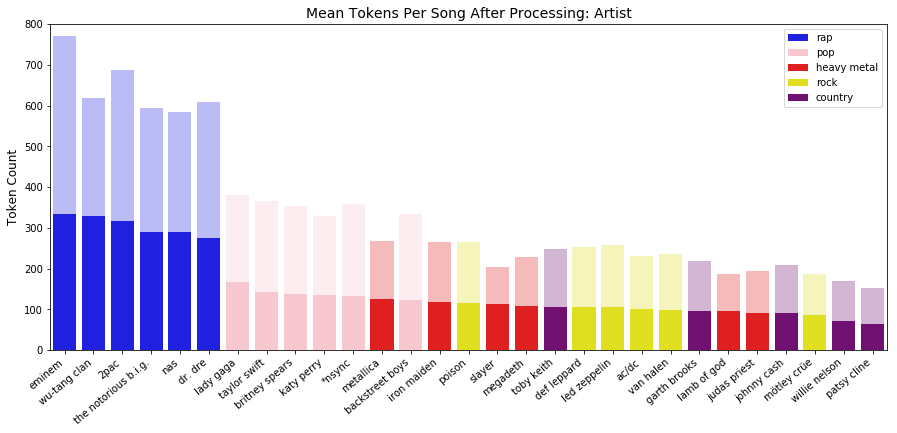

In [9]:
# Plot difference in mean token counts per song by artist before and after processing.
artist_mean_no_stops = pd.concat((master.artist, master.processed_token_count), axis=1).groupby('artist').mean()
artist_mean_no_stops = pd.concat((artist_mean_no_stops, genres), axis=1, ignore_index=True)
artist_mean_no_stops.columns = ['word_count', 'genre']
artist_mean_no_stops = artist_mean_no_stops.sort_values('word_count', ascending=False)
artist_mean_tokens = artist_mean_tokens.reindex(artist_mean_no_stops.index)

colormap = {'heavy metal': 'red', 
            'rap': 'blue', 
            'pop': 'pink', 
            'country': 'purple', 
            'rock': 'yellow'}

plt.figure(figsize=(15,6))
sns.barplot(x=artist_mean_no_stops.index, 
            y=artist_mean_no_stops.word_count, 
            data=artist_mean_no_stops, 
            hue='genre', 
            dodge=False, 
            palette=colormap)

handles, labels = sns.barplot(x=artist_mean_tokens.index, 
                              y=artist_mean_tokens.word_count, 
                              data=artist_mean_tokens, 
                              hue='genre', 
                              dodge=False, 
                              palette=colormap,
                              alpha=.3).get_legend_handles_labels()
plt.xticks(rotation=40, ha='right')
plt.xlabel('')
plt.ylabel('Token Count', fontsize=12)
plt.ylim(0,800)
plt.title('Mean Tokens Per Song After Processing: Artist', fontsize=14)
plt.legend(handles[0:5], labels[0:5])
plt.show()

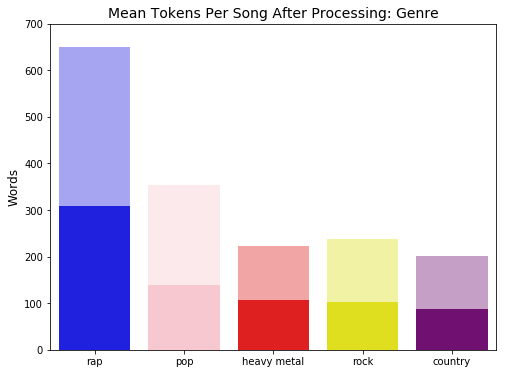

In [10]:
# Plot difference in mean token counts per song by artist before and after processing.
genre_mean_no_stops = pd.concat((master.genre, master.processed_token_count), axis=1).groupby('genre').mean()
genre_mean_no_stops.columns = ['word_count']
genre_mean_no_stops = genre_mean_no_stops.sort_values('word_count', ascending=False)
genre_mean_tokens = genre_mean_tokens.reindex(genre_mean_no_stops.index)

colormap = {'heavy metal': 'red', 
            'rap': 'blue', 
            'pop': 'pink', 
            'country': 'purple', 
            'rock': 'yellow'}

plt.figure(figsize=(8,6))
sns.barplot(x=genre_mean_no_stops.index, 
            y=genre_mean_no_stops.word_count, 
            data=genre_mean_no_stops, 
            hue=genre_mean_no_stops.index, 
            dodge=False, 
            palette=colormap).legend_.remove()

sns.barplot(x=genre_mean_tokens.index, 
            y=genre_mean_tokens.word_count, 
            data=genre_mean_tokens, 
            hue=genre_mean_tokens.index, 
            dodge=False, 
            palette=colormap, 
            alpha=.4).legend_.remove()
plt.xlabel('')
plt.ylabel('Words', fontsize=12)
plt.ylim(0,700)
plt.title('Mean Tokens Per Song After Processing: Genre', fontsize=14)
plt.show()

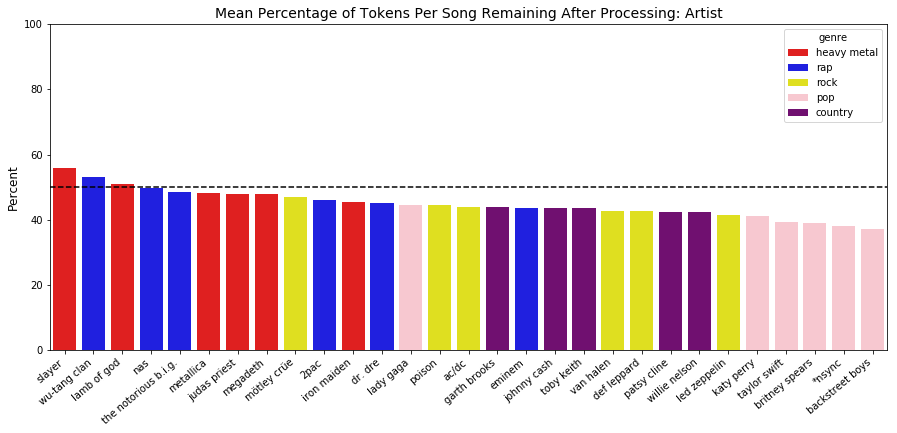

In [11]:
# Plot percent of tokens remaining per song by artist after processing.
percent_remaining = (master.processed_token_count / master.total_token_count)*100
master['token_%_remaining'] = percent_remaining

artist_mean_percent = pd.concat((master.artist, percent_remaining), axis=1).groupby('artist').mean()
artist_mean_percent = pd.concat((artist_mean_percent, genres), axis=1, ignore_index=True)
artist_mean_percent.columns = ['word_count', 'genre']
artist_mean_percent = artist_mean_percent.sort_values('word_count', ascending=False)

colormap = {'heavy metal': 'red', 
            'rap': 'blue', 
            'pop': 'pink', 
            'country': 'purple', 
            'rock': 'yellow'}

plt.figure(figsize=(15,6))
sns.barplot(x=artist_mean_percent.index, 
            y=artist_mean_percent.word_count, 
            data=artist_mean_percent, 
            hue='genre', 
            dodge=False, 
            palette=colormap)
plt.xticks(rotation=40, ha='right')
plt.axhline(50, linestyle='--', color='black')
plt.xlabel('')
plt.ylabel('Percent', fontsize=12)
plt.ylim(0, 100)
plt.title('Mean Percentage of Tokens Per Song Remaining After Processing: Artist', fontsize=14)
plt.show()

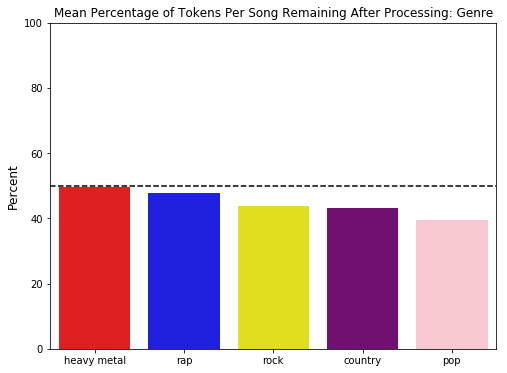

In [12]:
# Plot percent of tokens remaining per song by genre after processing.
genre_mean_percent = pd.concat((master.genre, percent_remaining), axis=1).groupby('genre').mean()
genre_mean_percent.columns = ['word_count']
genre_mean_percent = genre_mean_percent.sort_values('word_count', ascending=False)

colormap = {'heavy metal': 'red', 
            'rap': 'blue', 
            'pop': 'pink', 
            'country': 'purple', 
            'rock': 'yellow'}

plt.figure(figsize=(8,6))
sns.barplot(x=genre_mean_percent.index, 
            y=genre_mean_percent.word_count,  
            hue=genre_mean_percent.index, 
            dodge=False, 
            palette=colormap).legend_.remove()
plt.axhline(50, linestyle='--', color='black')
plt.xlabel('')
plt.ylabel('Percent', fontsize=12)
plt.ylim(0, 100)
plt.title('Mean Percentage of Tokens Per Song Remaining After Processing: Genre', fontsize=12)
plt.show()

In [13]:
genre_mean_percent

,word_count
genre,
heavy metal,49.477476
rap,47.855559
rock,43.640734
country,43.155086
pop,39.607178


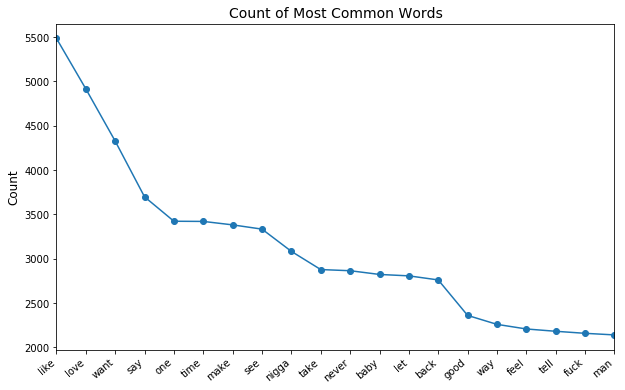

In [14]:
# Plot 20 most common tokens in all songs.
all_tokens = []

for line in master.processed_tokens:
    tokens = nltk.tokenize.word_tokenize(line)
    all_tokens.extend(tokens)
    
plt.figure(figsize=(10,6))
S = pd.Series(all_tokens).value_counts().head(20)
pl = S.plot(marker='o')
pl.set_xticks(np.arange(len(S)))
pl.set_xticklabels(np.array(S.index))
plt.xticks(rotation=40, ha='right')
plt.title('Count of Most Common Words', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.show()

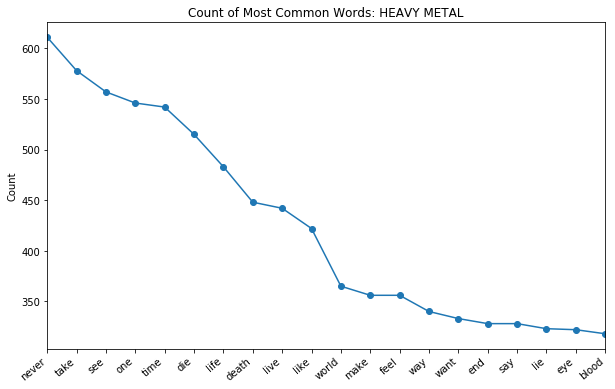

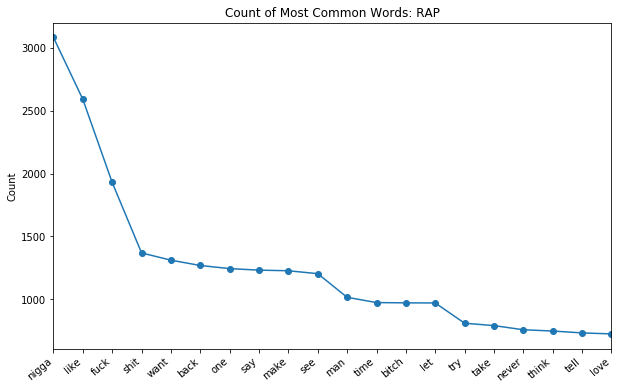

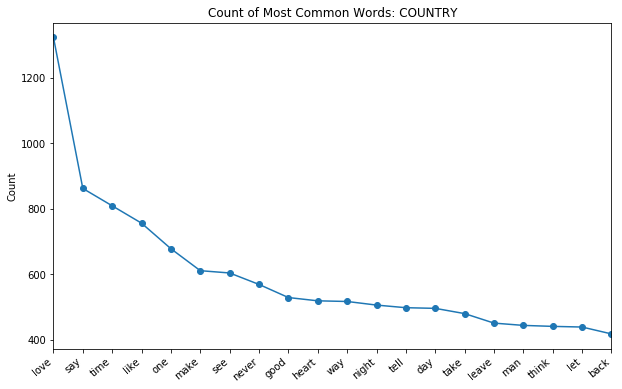

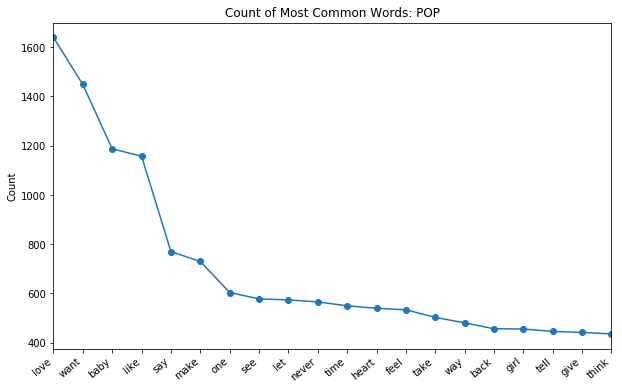

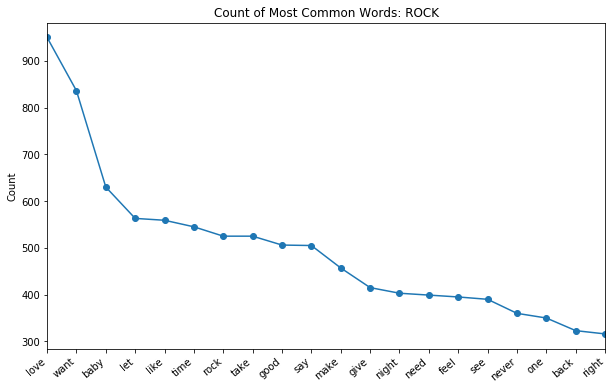

In [15]:
# Plot 20 most common tokens per genre.
all_genre_tokens = []
for genre in master.genre.unique():
    genre_tokens = []
    for line in master[master.genre == genre].processed_tokens:
        tokens = nltk.tokenize.word_tokenize(line) 
        genre_tokens.extend(tokens)
    

    plt.figure(figsize=(10,6))
    S = pd.Series(genre_tokens).value_counts().head(20)
    pl = S.plot(marker='o')
    pl.set_xticks(np.arange(len(S)))
    pl.set_xticklabels(np.array(S.index))
    plt.xticks(rotation=40, ha='right')
    plt.title('Count of Most Common Words: ' + str(genre).upper())
    plt.ylabel('Count')
    plt.show()
    all_genre_tokens.append(S.index.values)

In [16]:
# Find 50 most common words for each genre, than return those that were unique to each genre.
df_list = []
all_unique_tokens = []
token_dic = {}

for genre in master.genre.unique():
    genre_token_list = []
    for line in master[master.genre == genre].processed_tokens:
        tokens = nltk.tokenize.word_tokenize(line)
        genre_token_list.extend(tokens)
    df = pd.DataFrame({'tokens':pd.Series(genre_token_list).value_counts().head(50).index, 'genre': genre})
    df_list.append(df)
    
df = pd.concat(df_list).reset_index(drop=True)

for genre in df.genre.unique():
    unique_tokens = [token for token in df[df['genre'] == genre].tokens.values 
                     if token not in df[df['genre'] != genre].tokens.values]
    token_dic[genre] = unique_tokens
    all_unique_tokens.extend(unique_tokens)

all_common_tokens = []
for genre in master.genre.unique():
    for line in master[master.genre == genre].processed_tokens:
        tokens = nltk.tokenize.word_tokenize(line)
        common_tokens = [token for token in tokens if token in all_unique_tokens]
        all_common_tokens.append(' '.join(common_tokens))
    
master['common_tokens'] = all_common_tokens

for key in token_dic.keys():
    print(str(key) + ':')
    print(str(token_dic[key]))
    print('')

heavy metal:
['death', 'end', 'lie', 'blood', 'hell', 'dead', 'burn', 'hand', 'soul', 'kill', 'pain', 'lose', 'fear', 'inside']

rap:
['nigga', 'fuck', 'shit', 'bitch', 'real', 'hit', 'street', 'put', 'two', 'black', 'motherfucker', 'big', 'game']

country:
['old', 'walk', 'find', 'cry', 'blue', 'home', 'always', 'hold']

pop:
['dance', 'tonight', 'show', 'wish', 'stay', 'everything', 'stop']

rock:
['rock', 'roll', 'woman', 'bad', 'stand', 'talk', 'really', 'turn', 'play']



A decent summary of each genre's common lyrical themes.

In [17]:
# Go through 20 most common tokens per genre and return those that are found in all five.
unique_tokens = []
for token in all_tokens:
    if token not in unique_tokens:
        unique_tokens.append(token)
        
list1 = [token for token in unique_tokens 
         if token in all_genre_tokens[0] 
         and token in all_genre_tokens[1] 
         and token in all_genre_tokens[2] 
         and token in all_genre_tokens[3] 
         and token in all_genre_tokens[4]]
print(list1)

['say', 'one', 'take', 'never', 'make', 'time', 'see', 'like']


              precision    recall  f1-score   support

     country       0.85      0.90      0.87       230
 heavy metal       0.86      0.78      0.82       149
         pop       0.67      0.78      0.72       116
         rap       0.96      0.97      0.96       148
        rock       0.64      0.52      0.58       109

    accuracy                           0.82       752
   macro avg       0.80      0.79      0.79       752
weighted avg       0.81      0.82      0.81       752

Accuracy Score: 0.82


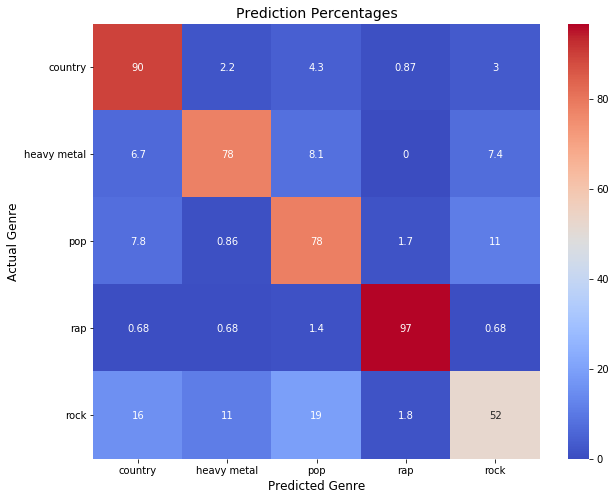

In [66]:
# Construct Naive Bayes model for predicting genre of lyrics.

# Create word vectors.
cv = CountVectorizer() 

A = cv.fit_transform(master['processed_tokens']).toarray()
B = master.drop(['lyrics', 'song', 'album', 'artist', 'genre', 'processed_tokens', 'token_pos', 'common_tokens'], axis=1).to_numpy()
C = cv.fit_transform(master['token_pos']).toarray()
D = cv.fit_transform(master.common_tokens).toarray()
E = master[['song', 'artist']].to_numpy()

# Define "X" and "y" variables.
X = np.concatenate((A,B,C,D,E), axis=1)
y = master['genre']

# Define training and testing sets, fit model and predict.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0) 

# MNB = MultinomialNB().fit(X_train, y_train)
MNB = MultinomialNB().fit(np.delete(X_train, np.s_[17261:], axis=1), y_train)

# y_pred = MNB.predict(X_test)
y_pred = MNB.predict(np.delete(X_test, np.s_[17261:], axis=1))

# Print classification report and accuracy score.
mnb_class_report = classification_report(y_test,y_pred)
print(mnb_class_report)
print('Accuracy Score: {}'.format(round(accuracy_score(y_test, y_pred), 2)))

# Plot confusion matrix as heatmap.
plt.figure(figsize=(10,8))
sns.heatmap(pd.crosstab(y_test, y_pred).apply(lambda r: (r/r.sum())*100, axis=1), cmap='coolwarm', annot=True)
plt.yticks(va='center', rotation=0)
plt.xlabel('Predicted Genre', fontsize=12)
plt.ylabel('Actual Genre', fontsize=12)
plt.title('Prediction Percentages', fontsize=14)
plt.show()

Naive Bayes modeling yielding an accuracy score of 82%, which is pretty good.  The amount of cleaning and pre-processing I did prior to modeling likely helped.

In [187]:
mnb_df = pd.DataFrame(X_test[:,[17261,17262]])
mnb_df['genre'] = y_test.values
mnb_df['predicted_genre'] = y_pred
mnb_df.columns = ['song', 'artist', 'genre', 'predicted_genre']

ct = pd.crosstab(y_test, y_pred).apply(lambda r: (r/r.sum())*100, axis=1)

for genre in mnb_df.genre.unique():
    df = mnb_df[(mnb_df['genre'] != mnb_df.predicted_genre) & (mnb_df['genre'] == genre)]
    print(genre.upper())
    print('Misclassification Percent: ' + str(round(ct.loc[genre].drop(genre).sum(), 2)))
    print('Breakdown:')
    print(round(df.predicted_genre.value_counts()/len(df)*100), 2)
    print('')

ROCK
Misclassification Percent: 47.71
Breakdown:
pop            40.0
country        33.0
heavy metal    23.0
rap             4.0
Name: predicted_genre, dtype: float64 2

RAP
Misclassification Percent: 3.38
Breakdown:
pop            40.0
rock           20.0
country        20.0
heavy metal    20.0
Name: predicted_genre, dtype: float64 2

COUNTRY
Misclassification Percent: 10.43
Breakdown:
pop            42.0
rock           29.0
heavy metal    21.0
rap             8.0
Name: predicted_genre, dtype: float64 2

POP
Misclassification Percent: 21.55
Breakdown:
rock           52.0
country        36.0
rap             8.0
heavy metal     4.0
Name: predicted_genre, dtype: float64 2

HEAVY METAL
Misclassification Percent: 22.15
Breakdown:
pop        36.0
rock       33.0
country    30.0
Name: predicted_genre, dtype: float64 2



Rock had the highest misclassification rate at approximately 47%.  Of those, 4% were classified as rap.

In [188]:
mnb_df[(mnb_df['genre'] != mnb_df.predicted_genre) & (mnb_df['genre'] == 'rock') & (mnb_df['predicted_genre'] == 'rap')]

,song,artist,genre,predicted_genre
379,smokin' in the boys room,mötley crüe,rock,rap
404,given the dog a bone,ac/dc,rock,rap


Not sure how Mötley Crüe or AC/DC were classified as rap.  Otherwise, rock can have a bit of crossover with elements of pop, country and metal so it's not entirely surprising that the model struggled there.

In [192]:
mnb_df[(mnb_df['genre'] != mnb_df.predicted_genre) & (mnb_df['genre'] == 'rap')]

,song,artist,genre,predicted_genre
21,bar one,dr. dre,rap,rock
227,the greatest rapper (interlude),the notorious b.i.g.,rap,heavy metal
381,space bound,eminem,rap,pop
655,you won't see me tonight,nas,rap,pop
725,you wouldn't understand,nas,rap,country


As for the mislabeled rap songs, "Bar One" and "The Greatest Rapper (Interlude)" are both spoken skits which are somewhat common on rap albums.  Labeling as pop makes some sense, and "Spacebound" was more radio-friendly then most of Eminem's work.  Labeling as country is odd...

In [204]:
master[master.song == "you wouldn't understand"].lyrics.item()

"(Featuring: Victoria Monet)  (Verse: Nas) You never knew how to make dollars You couldn't make orders at a drive-through McDonald's I was fly at the Apollo with black Jason, '89 with a bottle Jealous of Jason, dark green seven forty no tint Rollie on wrist, gleamin' he rock the baldy Used to ride with him to Brooklyn, louis, and hallsey Cop chocolate tie, burnin' style and burn it down Got hype in the federal joint, verdict out 20 years gettin' money in the dirty south That's alleged, you see my nigga's a stand up dude So I'm yellin' free my nigga My nephew..."

This particular song is short by rap standards and since coutnry songs in my samples were commonly the shortest, that could have made a difference.

In [206]:
mnb_df[(mnb_df['genre'] != mnb_df.predicted_genre) & (mnb_df['genre'] == 'country') & (mnb_df['predicted_genre'] == 'rap')]

,song,artist,genre,predicted_genre
23,ballad of the harp weaver,johnny cash,country,rap
128,jacky don tucker (play by the rules miss all t...,toby keith,country,rap


Similarly hard to see how Johnny Cash or Toby Keith could be labeled as rap.

I'd like to try another model to see how it may perform.  

              precision    recall  f1-score   support

     country       0.73      0.93      0.82       230
 heavy metal       0.84      0.79      0.81       149
         pop       0.79      0.72      0.75       116
         rap       0.98      0.99      0.99       148
        rock       0.64      0.38      0.47       109

    accuracy                           0.80       752
   macro avg       0.80      0.76      0.77       752
weighted avg       0.80      0.80      0.79       752

Accuracy Score: 0.8


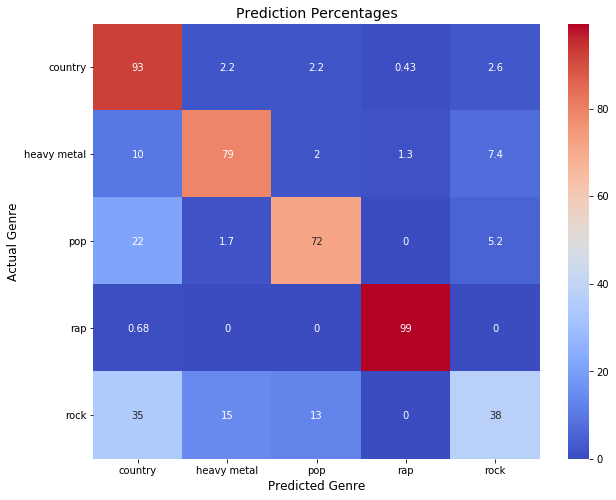

In [208]:
# Construct Random Forest model for predicting genre of lyrics.

from sklearn.ensemble import RandomForestClassifier

# Create word vectors.
A = cv.fit_transform(master['processed_tokens']).toarray()
B = master.drop(['lyrics', 'song', 'album', 'artist', 'genre', 'processed_tokens', 'token_pos', 'common_tokens'], axis=1).to_numpy()
C = cv.fit_transform(master['token_pos']).toarray()
D = cv.fit_transform(master.common_tokens).toarray()

# Define "X" and "y" variables.
X = np.concatenate((A,B,C,D), axis=1)
y = master['genre']

# Define training and testing sets, fit model and predict.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0) 

rfc = RandomForestClassifier(n_estimators=1500, random_state=0).fit(X_train, y_train)

y_pred = rfc.predict(X_test)

# Print classification report and accuracy score.
rfc_class_report = classification_report(y_test,y_pred)
print(rfc_class_report)
print('Accuracy Score: {}'.format(round(accuracy_score(y_test, y_pred), 2)))

# Plot confusion matrix as heatmap.
plt.figure(figsize=(10,8))
sns.heatmap(pd.crosstab(y_test, y_pred).apply(lambda r: (r/r.sum())*100, axis=1), cmap='coolwarm', annot=True)
plt.yticks(va='center', rotation=0)
plt.xlabel('Predicted Genre', fontsize=12)
plt.ylabel('Actual Genre', fontsize=12)
plt.title('Prediction Percentages', fontsize=14)
plt.show()

Comparable to Naive Bayes, but notably worse at labeling rock.  Rap remains the most accurate.

              precision    recall  f1-score   support

     country       0.93      0.37      0.53       230
 heavy metal       0.34      0.90      0.49       149
         pop       1.00      0.01      0.02       116
         rap       0.85      0.97      0.91       148
        rock       0.35      0.30      0.32       109

    accuracy                           0.53       752
   macro avg       0.69      0.51      0.45       752
weighted avg       0.72      0.53      0.49       752

Accuracy Score: 0.53


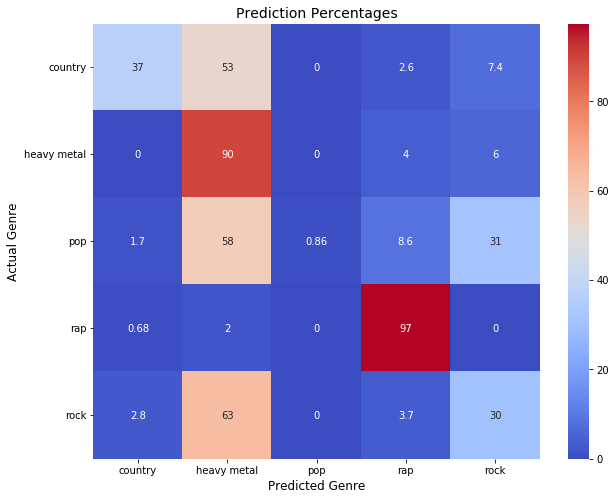

In [23]:
# Construct SGD model for predicting genre of lyrics.
from sklearn.linear_model import SGDClassifier

# Create word vectors.
A = cv.fit_transform(master['processed_tokens']).toarray()
B = master.drop(['lyrics', 'song', 'album', 'artist', 'genre', 'processed_tokens', 'token_pos', 'common_tokens'], axis=1).to_numpy()
C = cv.fit_transform(master['token_pos']).toarray()
D = cv.fit_transform(master.common_tokens).toarray()

# Define "X" and "y" variables.
X = np.concatenate((A,B,C,D), axis=1)
y = master['genre']

# Define training and testing sets, fit model and predict.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0) 

svm = SGDClassifier().fit(X_train, y_train)

y_pred = svm.predict(X_test)

# Print classification report and accuracy score.
svm_class_report = classification_report(y_test,y_pred)
print(svm_class_report)
print('Accuracy Score: {}'.format(round(accuracy_score(y_test, y_pred), 2)))

# Plot confusion matrix as heatmap.
plt.figure(figsize=(10,8))
sns.heatmap(pd.crosstab(y_test, y_pred).apply(lambda r: (r/r.sum())*100, axis=1), cmap='coolwarm', annot=True)
plt.yticks(va='center', rotation=0)
plt.xlabel('Predicted Genre', fontsize=12)
plt.ylabel('Actual Genre', fontsize=12)
plt.title('Prediction Percentages', fontsize=14)
plt.show()

Again, rap looks very accurate and there is a bump for metal, but SGD seems to classify a lot as heavy metal and performs poorly with other genres.

**Summary:** Using naive bayes,rap was the most successfully classified genre (97%), which is understandable given the volume of tokens per song and the relatively unique use of language.  Country also has a fairly unique lyrical syntax which would bolster the success of predictions there (90%).  Rock was difficult to label, which could illustrate that the genre is more generic in terms of content and construction.  It may have more common for elements of rock to spill into country, pop and metal than I expected and there are not enough unique elements to truly set it apart.  I feel more data (songs / lyrics) woud boost the performance of the model, but considering the rather arbitrary nature of genre labeling, I'd say the model works better than expected.